# 【課題】量子カーネルを使った新現象の分類

これまで、量子・古典ハイブリッドアルゴリズムの一つである{doc}`量子回路学習 <vqc_machine_learning>`の手法を使って、素粒子物理での新粒子探索が可能かを見てきました。ここでは、**量子機械学習**の別の手法として、**量子カーネル**を用いた分類を考えてみます。特に、量子カーネルを活用した**サポートベクターマシン**の手法{cite}`quantum_svm`を使って、同じ新粒子探索の問題に取り組みます。

```{contents} 目次
---
local: true
---
```

$\newcommand{\ket}[1]{| #1 \rangle}$
$\newcommand{\expval}[3]{\langle #1 | #2 | #3 \rangle}$

(q_kernel)=
## 量子カーネル

変分量子回路を使った量子回路学習では、

$$
U_{\text{in}}(x_i) = \prod_j R_j^Z(\cos^{-1}(x^2))R_j^Y(\sin^{-1}(x))
$$

と定義した特徴量マップ$U_{\text{in}}(x_i)$を考えました。それを初期状態$\ket{0}^{\otimes n}$に適用することで、入力データから$\ket{\phi(x_i)}=U_{\text{in}}(x_i)\ket{0}^{\otimes n}$という量子状態を作りました。**量子カーネル**とは、この状態の内積$\langle\phi(x_j)|\phi(x_i)\rangle$（の絶対値2乗）

$$
K(x_i,x_j):=|\langle\phi(x_j)|\phi(x_i)\rangle|^2=|\langle0^{\otimes n}|U_{\text{in}}^\dagger(x_j)U_{\text{in}}(x_i)|0^{\otimes n}\rangle|^2
$$

として定義される量です。量子カーネルの物理的な意味ですが、内積というものが表す通り、$\ket{\phi(x_i)}$と$\ket{\phi(x_j)}$の「近さ」あるいは「重なり具合」を表していると解釈できます。

(q_kernel_imp)=
### 量子カーネルの評価

量子カーネルを求めるためには、学習データの全てのペア$\{x_i,x_j\}$に対して、$K(x_i,x_j)=|\langle\phi(x_j)|\phi(x_i)\rangle|^2$を計算する必要があります。ここで「カーネルトリック」という言葉がよく使われますが、ヒルベルト空間での座標変数に明示的に依存しない形で$K(x_i,x_j)$を計算するために、以下のような量子回路を考えます。

```{image} figs/qke_circuit.png
:alt: qke_circuit
:width: 700px
:align: center
```

この回路に入力データ$x_i$と$x_j$をエンコードして、回路の出力状態を$Z$基底で測定するとします。カーネルの定義式から明らかなように、その時に全ての量子ビットが0になる（$0^n$ビット列が出てくる）確率が$K(x_i,x_j)$の評価値を与えてくれます。これを全てのペアに対して繰り返し実行し、カーネル行列の要素を決めていくことになるわけです。$0^n$ビット列測定によってカーネルを決めるため、量子回路の測定回数$N$に対して${\cal O}(1/\sqrt{N})$程度の誤差がついてしまうのは仕方ないところです。

(svm)=
## サポートベクターマシン

上までのステップでカーネル行列が得られましたが、次にこのカーネル行列をサポートベクターマシンと呼ばれる手法に取り入れて、2クラスのデータ分類を行なってみます。

### 2クラス線形分離問題

まず、2クラスの線形分離問題とはどういうものかを見ていきます。サンプル数$N$の学習データを$\{(\mathbf{X}_i,y_i)\}\:(i=1,\ldots,N)$とし、$\mathbf{X}_i \in \mathbb{R}^d$をインプット、$y_i\in\{+1,-1\}$をラベルと呼びます。分離問題とは、インプットの分布する空間$\mathbb{R}^d$に境界を定義し、ラベルの値が$+1$であるデータ点が属する領域と$-1$であるデータ点が属する領域に分けることを指します。そして、その境界が超平面である場合を線形分離と呼びます。ここで超平面とは、ある$\mathbf{w}\in\mathbb{R}^d, b \in \mathbb{R}$に対して集合

$$
\{\mathbf{X}| \mathbf{X} \in \mathbb{R}^d, \: \mathbf{w}\cdot\mathbf{X}+b=0\}
$$

を指します。ベクトル$\mathbf{w}$はこの超平面に直交し、そのノルムを$\lVert \mathbf{w} \rVert$と書くと、$b/\lVert \mathbf{w} \rVert$がこの超平面と原点との符号付き距離（$\mathbf{w}$の方向が正）に対応します。

超平面というのはシンプルであるがゆえに特殊な集合なので、学習データの分布のしかたによっては、超平面では分離できないケースもあり得ます。そのような分離が可能であるということは、

```{math}
:label: linear_separation
S_i(\mathbf{w}, b) := y_i(\mathbf{w}\cdot\mathbf{X}_i+b) \geq 1,\:\:\:\forall i=1,\ldots,N
```

を満たす$(\mathbf{w},b)$が存在することと等価です。この式の解釈ですが、括弧の中身$\mathbf{w} \cdot \mathbf{X}_i + b$はデータ点$X_i$と超平面$(\mathbf{w}, b)$との符号付き距離の$\lVert \mathbf{w} \rVert$倍で、それに$y_i$をかけた結果が1よりも大きいということは、$y_i=1$のデータ点が超平面について正の領域、$y_i=-1$のデータ点が負の領域にあり、かつどの点も超平面から$1/\lVert \mathbf{w} \rVert$以上離れているということを意味します。

さて、機械学習の目的は、学習データを元に何らかのモデルを作り、それを使って未知のインプットについて予言をすることにあります。今の分離問題においては、$(\mathbf{w}, b)$がモデルにあたり、未知インプット$X$についてのラベル$y$の予言は

```{math}
:label: test_data_label
y = \mathrm{sgn}(\mathbf{w} \cdot \mathbf{X} + b)
```

（$\mathrm{sgn}(z)$は$z \in \mathbb{R}$の符号）で与えられます。このとき、学習データを最も「強く」2分割するようなモデルが、未知データについて最も精度の高い予言をできると仮定します。「強く」2分割するというのは、超平面とすべての学習データ点との距離$1/\lVert \mathbf{w} \rVert$が大きいことに相当します。線形分離が可能な学習データについて式{eq}`linear_separation`を満たす$(\mathbf{w}, b)$は一意ではありませんが、その中で$\lVert \mathbf{w} \rVert$が最も小さくなるものが、最適なモデルということになります。

線形分離ができないような学習データについても、これと同じような発想で「できる限り」分離するという問題を考えることができます。この場合、学習とは$\lVert \mathbf{w} \rVert$ができるだけ小さく、かつ$\sum_{i} S_i(\mathbf{w}, b)$ができるだけ大きくなるような$\mathbf{w}$と$b$を探すことに相当し、以下の目的関数

```{math}
:label: primal_1
f(\mathbf{w}, b) = \frac{1}{2} \lVert \mathbf{w} \rVert^2 + C \sum_{i=1}^{N} \mathrm{max}\left(0, 1 - S_i(\mathbf{w}, b)\right)
```

の最小化で達成されます。ここで、係数$C>0$は、二つの目的のうちどちらをどれだけ優先するかを調整する「ハイパーパラメータ」です。第二項では$\mathrm{max}$関数で$S_i$の値が1以上になる（超平面から十分離れている）データ点を無視しています。無視されていない、つまり分離超平面付近にあったり誤って分類されたりしたデータ点インプット$\{\mathbf{X}_i | S_i < 1\}$のことを「サポートベクター」と呼びます。どのデータ点がサポートベクターとなるかは$\mathbf{w}$と$b$の値によりますが、一度$f$を最小化するパラメータ値が決まれば、未知インプットについての予言には、対応するサポートベクターのみが使用されます（どのように使われるかは後述します）。このような機械学習モデルをサポートベクターマシンと呼びます。

### 双対形式

次に、この最適化問題（主形式）の「双対問題」を見てみましょう。双対は、最適化問題に拘束条件を導入したラグランジアンを定義し、その停留点での値を未定定数の関数として表現し直すことで得られます。拘束条件の導入にはラグランジュの未定乗数法の拡張であるところのKarush-Kuhn-Tucker (KKT)の手法を用います。未定乗数法は拘束条件が等式で表されるときのみ使えるのに対し、KKT条件は不等式拘束条件にも対応します。

具体的には、まず式{eq}`primal_1`を$\mathrm{max}$関数を使わずに、パラメータ$\xi_i$を導入して次の形に書き換えます。

$$
\begin{align}
F(\mathbf{w}, b, \{\xi_i\}) & = \frac{1}{2} \lVert \mathbf{w} \rVert^2 + C \sum_{i=1}^{N} \xi_i \\
\text{with} & \: \xi_i \geq 1 - S_i, \: \xi_i \geq 0 \quad \forall i
\end{align}
$$

下行の拘束条件に従って$F$を最小化する$\mathbf{w}, b, \{\xi_i\}$が見つかったとき、$f$も最小化されることを確かめてください。

この最適化問題のラグランジアンは、非負の未定定数$\{\alpha_i\}$と$\{\beta_i\}$を導入して

```{math}
:label: lagrangian
L(\mathbf{w}, b, \{\xi_i\}; \{\alpha_i\}, \{\beta_i\}) = \frac{1}{2} \lVert \mathbf{w} \rVert^2 + C \sum_{i=1}^{N} \xi_i - \sum_{i=1}^{N} \alpha_i \left(\xi_i + S_i(\mathbf{w}, b) - 1\right) - \sum_{i=1}^{N} \beta_i \xi_i
```

で与えられます。停留点では

```{math}
:label: stationarity
\begin{align}
\frac{\partial L}{\partial \mathbf{w}} & = \mathbf{w} - \sum_i \alpha_i y_i \mathbf{X}_i = 0 \\
\frac{\partial L}{\partial b} & = -\sum_i \alpha_i y_i = 0 \\
\frac{\partial L}{\partial \xi_i} & = C - \alpha_i - \beta_i = 0
\end{align}
```

が成り立つので、式{eq}`lagrangian`にこれらの関係を代入すると、双対目的関数

```{math}
:label: dual
\begin{align}
G(\{\alpha_i\}) & = \sum_{i} \alpha_i - \frac{1}{2} \sum_{ij} \alpha_i \alpha_j y_i y_j \mathbf{X}_i \cdot \mathbf{X}_j \\
\text{with} & \sum_i \alpha_i y_i = 0, \: 0 \leq \alpha_i \leq C \quad \forall i
\end{align}
```

が得られます。双対問題は、この$G$を最大化する$\{\alpha_i\}$を見つける問題となります。また、主形式の最適解$\mathbf{w}^*, b^*, \{\xi^*_i\}$と双対問題の最適解$\{\alpha^*_i\}$との間に

```{math}
:label: complementarity
\begin{align}
\alpha^*_i (\xi^*_i + S_i(\mathbf{w}^*, b^*) - 1) & = 0 \\
\beta^*_i \xi^*_i = (C - \alpha^*_i) \xi^*_i & = 0
\end{align}
```

という関係（相補性条件）が成り立ちます。

### カーネル行列との関係

ここまで来てもカーネル行列とサポートベクターによる線形分離は一見無関係に思えますが、双対形式にヒントがあります。式{eq}`dual`に現れる$\mathbf{X}_i \cdot \mathbf{X}_j$はインプット空間を$\mathbb{R}^d$としたときのインプットベクトル同士の内積です。しかし、双対形式ではパラメータ$\mathbf{w}$が現れないので、$\mathbf{X}_i$が何か他の線形空間$V$の元であるとしても問題として成立します。さらに、実はそもそもこの部分がベクトルの内積である必要すらありません。インプットを何か（線形とは限らない）空間$D$の元$x_i$とし、$D$の二つの元$x_i$と$x_j$の間の何らかの「距離」を表す関数

$$
K: \: D \times D \to \mathbb{R}
$$

があるとします。すると、最も一般に、サポートベクターマシンとは、学習データ$\{(x_i, y_i) \in D \times \mathbb{R}\} \: (i=1,\ldots,N)$について目的関数

```{math}
:label: dual_kernel
\begin{align}
G(\{\alpha_i\}) & = \sum_{i} \alpha_i - \frac{1}{2} \sum_{ij} \alpha_i \alpha_j y_i y_j K(x_i, x_j) \\
\text{with} & \sum_i \alpha_i y_i = 0, \: \alpha_i \geq 0 \quad \forall i
\end{align}
```

を最大化する問題として定義できます。

上で定義したカーネル行列は、まさにこの距離関数$K(x_i, x_j)$に相当します。これでやっとカーネル行列をどうサポートベクターマシンに取り入れるのかが明らかになりました。

さて、式{eq}`complementarity`の相補性条件をよく眺めると、$\alpha^*_i, \xi^*_i, S^*_i$ ($S^*_i := S_i(\mathbf{w}^*, b^*)$)について

- $\alpha^*_i = C, \xi^*_i = 1 - S^*_i \geq 0$
- $\alpha^*_i = 0, \xi^*_i = 0$
- $0 < \alpha^*_i < C, \xi^*_i = 0, S^*_i = 1$

の3通りの値の組み合わせしかないことがわかります。特に、$S^*_i > 1$のとき$\alpha^*_i = 0$となります。すると、式{eq}`dual_kernel`における和はすべて$S^*_i \leq 1$であるような$i$、つまりサポートベクターについてのみ取ればいいことがわかります。

最後に、カーネル形式で表したサポートベクターマシンで学習を行った（$G$を最大化する$\{\alpha_i\}$を見つけた）ときに、未知データ$x$に対するラベルの予言がどう与えられるかを考えます。元の形式（主形式と呼びます）ではラベルが式{eq}`test_data_label`で与えられますが、ここに式{eq}`stationarity`の第一式を代入すると、

$$
y = \mathrm{sgn}\left(\sum_{i\in \mathrm{s.v.}} \alpha^*_i y_i K(x_i, x) + b^*\right)
$$

となります。ここで$\alpha^*_i$は$G$を最大化する最適パラメータで、$i$についての和はサポートベクターについてのみ取っています。パラメータ$b$の値の最適値$b^*$は、$S^*_j = 1$となるデータ点$j$について

$$
y_j \left(\sum_{i\in \mathrm{s.v.}} \alpha^*_i y_i K(x_i, x_j) + b^*\right)= 1
$$

を解くことで得られます。

(qsvm_imp)=
## 素粒子探索への応用

それでは、{doc}`ここ <vqc_machine_learning>`で考えた素粒子現象の探索問題に、量子サポートベクターマシンを応用してみましょう。

データセットの準備は同じです。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter, ParameterVector
from qiskit.circuit.library import TwoLocal, ZFeatureMap, ZZFeatureMap
from qiskit.primitives import Sampler
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator
from qiskit_machine_learning.kernels import FidelityQuantumKernel

/usr/local/lib/python3.10/dist-packages/dateutil/zoneinfo/__init__.py:26: UserWarning: I/O error(2): No such file or directory
  warnings.warn("I/O error({0}): {1}".format(e.errno, e.strerror))


In [2]:
# ファイルから変数を読み出す
df = pd.read_csv("data/SUSY_1K.csv",
                 names=('isSignal', 'lep1_pt', 'lep1_eta', 'lep1_phi', 'lep2_pt', 'lep2_eta',
                        'lep2_phi', 'miss_ene', 'miss_phi', 'MET_rel', 'axial_MET', 'M_R', 'M_TR_2',
                        'R', 'MT2', 'S_R', 'M_Delta_R', 'dPhi_r_b', 'cos_theta_r1'))

# 学習に使う変数の数
feature_dim = 3  # dimension of each data point

# 3, 5, 7変数の場合に使う変数のセット
if feature_dim == 3:
    selected_features = ['lep1_pt', 'lep2_pt', 'miss_ene']
elif feature_dim == 5:
    selected_features = ['lep1_pt', 'lep2_pt', 'miss_ene', 'M_TR_2', 'M_Delta_R']
elif feature_dim == 7:
    selected_features = ['lep1_pt', 'lep1_eta', 'lep2_pt', 'lep2_eta', 'miss_ene', 'M_TR_2', 'M_Delta_R']

# 学習に使う事象数: trainは訓練用サンプル、testはテスト用サンプル
train_size = 20
test_size = 20

df_sig = df.loc[df.isSignal==1, selected_features]
df_bkg = df.loc[df.isSignal==0, selected_features]

# サンプルの生成
df_sig_train = df_sig.values[:train_size]
df_bkg_train = df_bkg.values[:train_size]
df_sig_test = df_sig.values[train_size:train_size + test_size]
df_bkg_test = df_bkg.values[train_size:train_size + test_size]
# 最初のtrain_size事象がSUSY粒子を含む信号事象、残りのtrain_size事象がSUSY粒子を含まない背景事象
train_data = np.concatenate([df_sig_train, df_bkg_train])
# 最初のtest_size事象がSUSY粒子を含む信号事象、残りのtest_size事象がSUSY粒子を含まない背景事象
test_data = np.concatenate([df_sig_test, df_bkg_test])

# ラベル（信号事象では第1次元の第0要素が1、背景事象では第1次元の第1要素が1）
train_label = np.zeros(train_size * 2, dtype=int)
train_label[:train_size] = 1
test_label = np.zeros(train_size * 2, dtype=int)
test_label[:test_size] = 1

mms = MinMaxScaler((-1, 1))
norm_train_data = mms.fit_transform(train_data)
norm_test_data = mms.transform(test_data)

(problem1)=
### 問題1

各自特徴量マップを選び、`feature_map`という変数名の量子回路オブジェクトとして実装してください。{doc}`vqc_machine_learning`のように`ZFeatureMap`や`ZZFeatureMap`などのクラスを利用しても、自分で空の`QuantumCircuit`オブジェクトを作り、`Parameter`や`ParameterVector`を使って「手で」回路を書いても構いません。

使用する量子ビットの数も原則自由ですが、後で利用する`FidelityQuantumKernel`クラスはインプットの変数の数と量子ビット数が等しいときに一番うまく動作するようです。

In [3]:
##################
### EDIT BELOW ###
##################

#回路をスクラッチから書く場合
input_features = ParameterVector('x', feature_dim)
num_qubits = feature_dim
feature_map = QuantumCircuit(num_qubits)
# ...

##################
### EDIT ABOVE ###
##################

(problem2)=
### 問題2

問題1で決めた特徴量マップからカーネル行列要素を計算するための`manual_kernel`という変数名の量子回路を作ってください。Qiskitにはこれを自動でやってくれるAPI（`FidelityQuantumKernel`クラス）が準備されていますが、ここでは空の`QuantumCircuit`オブジェクトから始めて、上で決めた特徴量マップ回路からパラメータ付きの回路を作ってください。

**ヒント1**

QuantumCircuitオブジェクトに別のQuantumCircuitを貼り付けるには
```python
circuit.compose(another_circuit, inplace=True)
```
とします。このとき`inplace=True`を忘れると、`compose`メソッドは`circuit`に`another_circuit`を貼り付ける代わりに新しい回路オブジェクトを返してしまいます。

**ヒント2**

QuantumCircuitには`inverse()`という、逆回路を返すメソッドが備わっています。

**ヒント3**

`manual_kernel`のパラメータセットに注意してください。`feature_map`やその単純なコピーから`manual_kernel`を作っただけでは、後者は前者に使われるパラメータしか持ちません。

回路のパラメータセットを別のパラメータセットに置き換える方法として、

```python
current_parameters = circuit.parameters
new_parameters = ParameterVector('new_params', len(current_parameters))
bind_params = dict(zip(current_parameters, new_parameters))
new_circuit = circuit.assign_parameters(bind_params, inplace=False)
```

などがあります。この場合、`new_circuit`は`new_parameters`でパラメタライズされます。

In [4]:
manual_kernel = QuantumCircuit(feature_map.num_qubits)

##################
### EDIT BELOW ###
##################

##################
### EDIT ABOVE ###
##################

manual_kernel.measure_all()

作った量子回路をシミュレータで実行して、全ての量子ビットで0を測定する確率$|\langle0^{\otimes n}|U_{\text{in}}^\dagger(x_1)U_{\text{in}}(x_0)|0^{\otimes n}\rangle|^2$を計算します。

In [5]:
sampler = Sampler()

first_two_inputs = np.concatenate(norm_train_data[:2]).flatten()

job = sampler.run(manual_kernel, parameter_values=first_two_inputs, shots=10000)
# quasi_dists[0]がmanual_kernelの測定結果のcountsから推定される確率分布
fidelity = job.result().quasi_dists[0].get(0, 0.)
print(f'|<φ(x_0)|φ(x_1)>|^2 = {fidelity}')

ValueError: The number of values (6) does not match the number of parameters (0) for the 0-th circuit.

次に同じことを`FidelityQuantumKernel`クラスを利用して行います。

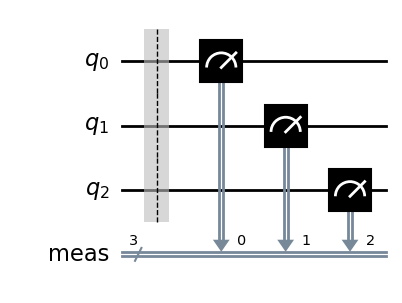

In [6]:
# FidelityQuantumKernelは内部で勝手にSamplerインスタンスを作る
q_kernel = FidelityQuantumKernel(feature_map=feature_map)

bind_params = dict(zip(feature_map.parameters, norm_train_data[0]))
feature_map_0 = feature_map.bind_parameters(bind_params)
bind_params = dict(zip(feature_map.parameters, norm_train_data[1]))
feature_map_1 = feature_map.bind_parameters(bind_params)

qc_circuit = q_kernel.fidelity.create_fidelity_circuit(feature_map_0, feature_map_1)
qc_circuit.decompose().decompose().draw('mpl')

`FidelityQuantumKernel`を使うと、カーネル行列を直接書き出して見ることも容易にできます。学習データから求めたカーネル行列と、学習データとテストデータから計算したカーネル行列をプロットしてみます。

In [7]:
matrix_train = q_kernel.evaluate(x_vec=norm_train_data)
matrix_test = q_kernel.evaluate(x_vec=norm_test_data, y_vec=norm_train_data)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asmatrix(matrix_train), interpolation='nearest', origin='upper', cmap='Blues')
axs[0].set_title("training kernel matrix")
axs[1].imshow(np.asmatrix(matrix_test), interpolation='nearest', origin='upper', cmap='Reds')
axs[1].set_title("validation kernel matrix")
plt.show()

ValueError: x_vec and class feature map have incompatible dimensions.
x_vec has 3 dimensions, but feature map has 0.

最後に、sklearnパッケージに実装されているサポートベクターマシンを使って分類を行います。量子回路学習の場合と同様に、データサイズや特徴量マップを変えるなどして分類精度がどう変わるか調べてみてください。

In [8]:
qc_svc = SVC(kernel='precomputed') # ハイパーパラメータ(C)のデフォルト値は1
qc_svc.fit(matrix_train, train_label)

train_score = qc_svc.score(matrix_train, train_label)
test_score = qc_svc.score(matrix_test, test_label)

print(f'Precomputed kernel: Classification Train score: {train_score*100}%')
print(f'Precomputed kernel: Classification Test score:  {test_score*100}%')

NameError: name 'matrix_train' is not defined

**提出するもの**
- 選んだ特徴量マップの説明とそのコード（問題１）
- カーネル行列要素を計算するための量子回路のコードと、その回路を使って計算した$K(x_0, x_1)$の値（問題２）
- この{doc}`ワークブック <vqc_machine_learning>`にある変分量子回路を使った量子機械学習との比較
   - 二つの方法を同じ条件（特徴量の変数、データサンプルのサイズ、特徴量マップ）で比較した時に、分類性能に対して何か系統的な違いは見えるでしょうか。特徴量やサンプルサイズを変えて比較するなどして、その振る舞いを自分なりに考察してみてください。
   - 一方が他方に比べて系統的に分類性能が悪くなっている場合、どうすれば悪い方を改善できるでしょうか。サンプルサイズが小さい時には、どちらの方法でも過学習（テストデータでの分類性能が訓練データでの分類性能より悪くなる）の傾向が見えていると思います。過学習をできるだけ抑えながら、分類性能を改善する方法がないか、考察してみてください。